## Plot pre-projected data defined in PDEF
**12 April 2020 by MiniUFO**

---
[TOC]

---
### 1. Introduction
The current [**xgrads**](https://github.com/miniufo/xgrads) package is capable of parsing `PDEF` info defined in `ctl` ([**see the doc here**](http://cola.gmu.edu/grads/gadoc/pdef.html)).  With a `PDEF` defined, the `ctl` contains two sets of grids.  One is the **native** grid with grid points given in `PDEF` and the data are known as **pre-projected** data.  Another is the rectilinear lat/lon grid commonly defined by `XDEF` and `YDEF`.  As a result, the number of grid points defined in `PDEF` is used for reading and converting to [**xarray.Dataset**](http://xarray.pydata.org/en/stable/).  The common lat/lon grid is used internally by [**GrADS**](http://cola.gmu.edu/grads/) for interpolation and displaying.  So the lat/lon grid and its resolution can be modified at will.

As a light-weighted package, [**xgrads**](https://github.com/miniufo/xgrads) does not intend to do the interpolation and display the interpolated fields as [**GrADS**](http://cola.gmu.edu/grads/) does.  For those who may want to do a similar job, this notebook is a quick guide to read the `ctl` file with `PDEF` and plot the pre-projected data with [**cartopy**](https://scitools.org.uk/cartopy/docs/latest/)


---
### 2. A case of Lambert Conformal Conic Projection (LCC)
The example `ctl` file is:

```python
dset ^EMI_2019_monthly.grd
options big_endian
title CUACE_emi_index  data
undef -9999.
pdef  360  320 nps   100 170 130  15
xdef  720 linear    0.00  0.5
ydef  682 linear   41.18  0.0676
zdef    1 levels 1
tdef   10 linear JAN2019   1mo
vars 12
emi_index       0  99  pm   u2/m3
demi_index      0  99  pm   u2/m3
emisdep_index   0  99  pm   u2/m3
diff_index      0  99  pm   u2/m3
trans_index     0  99  pm   u2/m3
trans_in        0  99  pm   u2/m3
trans_out       0  99  pm   u2/m3
surf_index      0  99  pm     1/1
semi_index      0  99  pm   u2/m3
sdemi_index     0  99  pm   u2/m3
emitest_index   0  99  pm   u2/m3
deptest_index   0  99  pm   u2/m3
endvars
```

First parse the `ctl` file as:

In [1]:
import sys
sys.path.append('../')
from xgrads import CtlDescriptor, open_CtlDataset


ctl = CtlDescriptor(file='d:/EMI_2019_monthly.ctl')

print(ctl.pdef)

isize: 360
jsize: 320
proj: lcc
latref: 35.0
lonref: 103.5
iref: 180.5
jref: 160.5
Struelat: 30.0
Ntruelat: 60.0
slon: 103.5
dx: 15000.0
dy: 15000.0


`PDEF` is parsed OK.  So load the data into `xarray.Dataset`:

In [2]:
dset = open_CtlDataset('d:/EMI_2019_monthly.ctl')

print(dset)

<xarray.Dataset>
Dimensions:        (time: 10, x: 360, y: 320)
Coordinates:
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-10-01
  * y              (y) float64 0.0 1.5e+04 3e+04 ... 4.77e+06 4.785e+06
  * x              (x) float64 0.0 1.5e+04 3e+04 ... 5.37e+06 5.385e+06
Data variables:
    emi_index      (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    demi_index     (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    emisdep_index  (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    diff_index     (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    trans_index    (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    trans_in       (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    trans_out      (time, y, x) >f4 dask.array<chunksize=(1, 320, 360), meta=np.ndarray>
    surf_index     (time, y, x) >f4 dask.array<chunksize=(1, 32

Plot the pre-projected data without map projection using [**xarray**](http://xarray.pydata.org/en/stable/)'s wrapper of [**matplotlib**](https://matplotlib.org/):

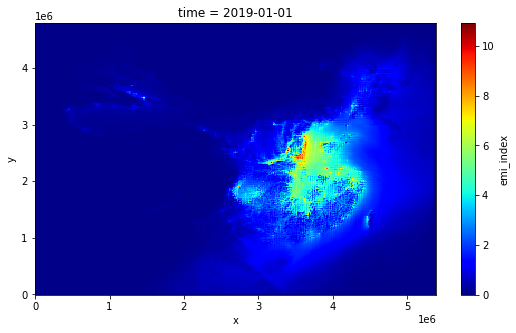

In [3]:
data = dset.emi_index[0]
data.where(data!=ctl.undef).plot(figsize=(9,5), cmap='jet')

Now we are going to display the pre-projected data on a map.  This is easy under the help of [**cartopy**](https://scitools.org.uk/cartopy/docs/latest/).  Notice that the `ctl` object has a `get_data_projection` function to provide a map projection in accordance with [**cartopy**](https://scitools.org.uk/cartopy/docs/latest/).

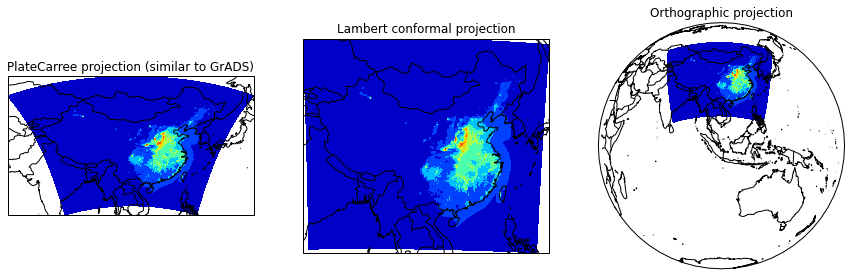

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

# this data projection is defined by PDEF, and will
# be used by cartopy for plotting.
data_proj = ctl.get_data_projection()

# Note that data projection is uniquely defined by PDEF.
# But we can plot the data in different map projections.
# Here choose three for demonstration.
map_proj_pcr = ccrs.PlateCarree(central_longitude=105)
map_proj_lcc = ccrs.LambertConformal(central_longitude=105)
map_proj_orth = ccrs.Orthographic(central_longitude=105)

plt.figure(figsize=(15,10))
ax = plt.subplot(131, projection = map_proj_pcr)
ax.contourf(data.x, data.y, data, transform=data_proj, cmap='jet')
ax.coastlines('50m')
ax.add_feature(cf.BORDERS)
ax.set_title('PlateCarree projection (similar to GrADS)')

ax = plt.subplot(132, projection = map_proj_lcc)
ax.contourf(data.x, data.y, data, transform=data_proj, cmap='jet')
ax.coastlines('50m')
ax.add_feature(cf.BORDERS)
ax.set_title('Lambert conformal projection')

ax = plt.subplot(133, projection = map_proj_orth)
ax.contourf(data.x, data.y, data, transform=data_proj, cmap='jet')
ax.coastlines('50m')
ax.add_feature(cf.BORDERS)
ax.set_title('Orthographic projection')
ax.set_global()

---
### 3. A case of North Polar Stereo projection (NPS)
The ctl file has been modified slightly as:
```python
dset ^EMI_2019_monthly.grd
options big_endian
title CUACE_emi_index  data
undef -9999.
pdef  360  320 nps   100 170 130  15
xdef  720 linear    0.00  0.5
ydef  682 linear   41.18  0.0676
zdef    1 levels 1
tdef   10 linear JAN2019   1mo
vars 12
emi_index        0  99  pm   u2/m3
demi_index       0  99  pm   u2/m3
emisdep_index    0  99  pm   u2/m3
diff_index       0  99  pm   u2/m3
trans_index      0  99  pm   u2/m3
trans_in         0  99  pm   u2/m3
trans_out        0  99  pm   u2/m3
surf_index       0  99  pm     1/1
semi_index       0  99  pm   u2/m3
sdemi_index      0  99  pm   u2/m3
emitest_index    0  99  pm   u2/m3
deptest_index    0  99  pm   u2/m3
endvars
```
Note the projection in `PDEF` becomes `nps`.  The loading and plotting is similar:

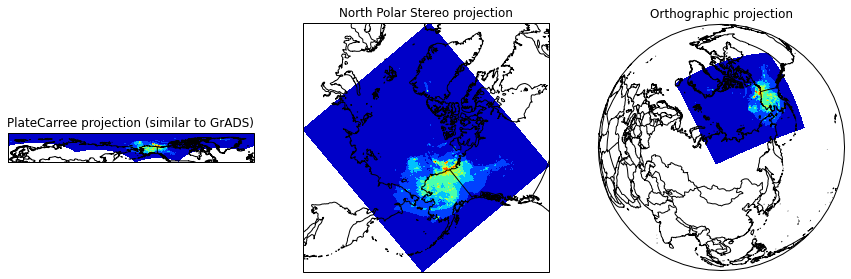

In [5]:
dset, ctl = open_CtlDataset('d:/EMI_2019_monthly2.ctl', returnctl=True)
data = dset.emi_index[0]

# this time it is North Polar Stereo (NPS) projection
data_proj = ctl.get_data_projection()

# Note that data projection is uniquely defined by PDEF.
# But we can plot the data in different map projections.
# Here choose three for demonstration.
map_proj_pcr = ccrs.PlateCarree(central_longitude=180)
map_proj_nps = ccrs.NorthPolarStereo(central_longitude=180)
map_proj_orth = ccrs.Orthographic(central_longitude=105, central_latitude=70)

plt.figure(figsize=(15,10))
ax = plt.subplot(131, projection = map_proj_pcr)
ax.contourf(data.x, data.y, data, transform=data_proj, cmap='jet')
ax.coastlines('50m')
ax.add_feature(cf.BORDERS)
ax.set_title('PlateCarree projection (similar to GrADS)')

ax = plt.subplot(132, projection = map_proj_nps)
ax.contourf(data.x, data.y, data, transform=data_proj, cmap='jet')
ax.coastlines('50m')
ax.add_feature(cf.BORDERS)
ax.set_title('North Polar Stereo projection')

ax = plt.subplot(133, projection = map_proj_orth)
ax.contourf(data.x, data.y, data, transform=data_proj, cmap='jet')
ax.coastlines('50m')
ax.add_feature(cf.BORDERS)
ax.set_title('Orthographic projection')
ax.set_global()

---
### 4. Summary

[GrADS](http://cola.gmu.edu/grads/) has two jobs with a `PDEF` ctl file.  One is loading the binary data and the other is plotting with proper map projection.  Here [xgrads](https://github.com/miniufo/xgrads) package will only do the loading task and let [cartopy](https://scitools.org.uk/cartopy/docs/latest/) do the plotting job. 

---
### References
[http://cola.gmu.edu/grads/gadoc/pdef.html](http://cola.gmu.edu/grads/gadoc/pdef.html)

[https://scitools.org.uk/cartopy/docs/latest/](https://scitools.org.uk/cartopy/docs/latest/)

[https://matplotlib.org/](https://matplotlib.org/)

[http://xarray.pydata.org/en/stable/](http://xarray.pydata.org/en/stable/)